In [ ]:
pip install shap lime lightgbm pandas

[LightGBM] [Info] Number of positive: 3966, number of negative: 4034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495750 -> initscore=-0.017000
[LightGBM] [Info] Start training from score -0.017000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
F1_score
0.4730507587650445


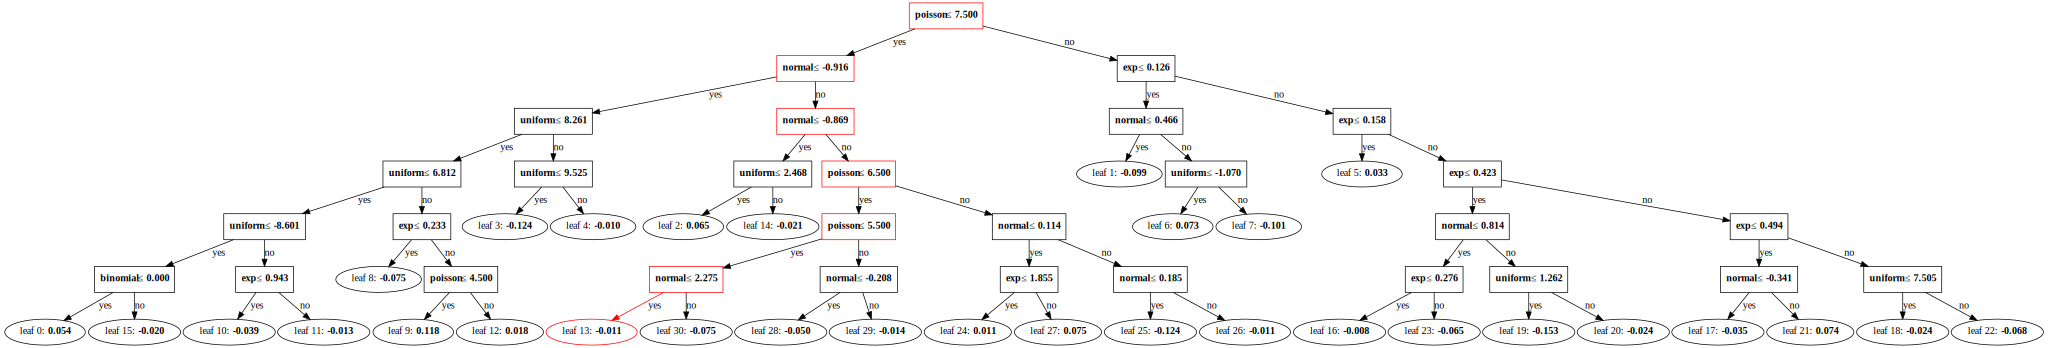

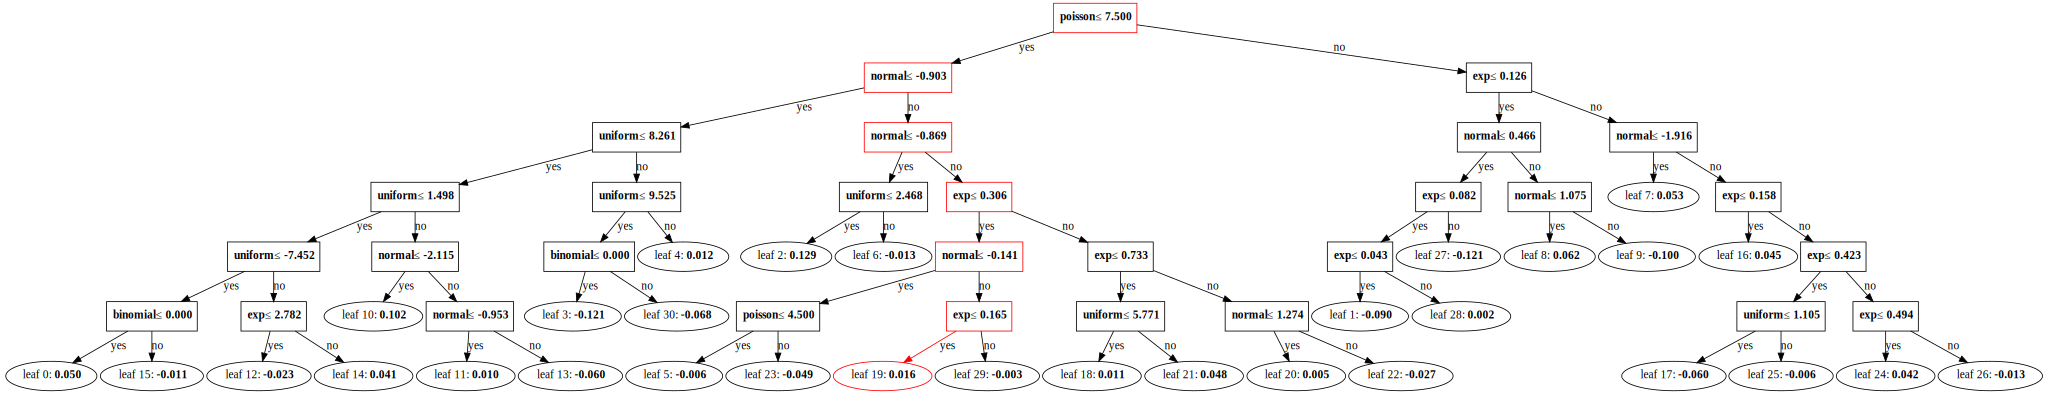

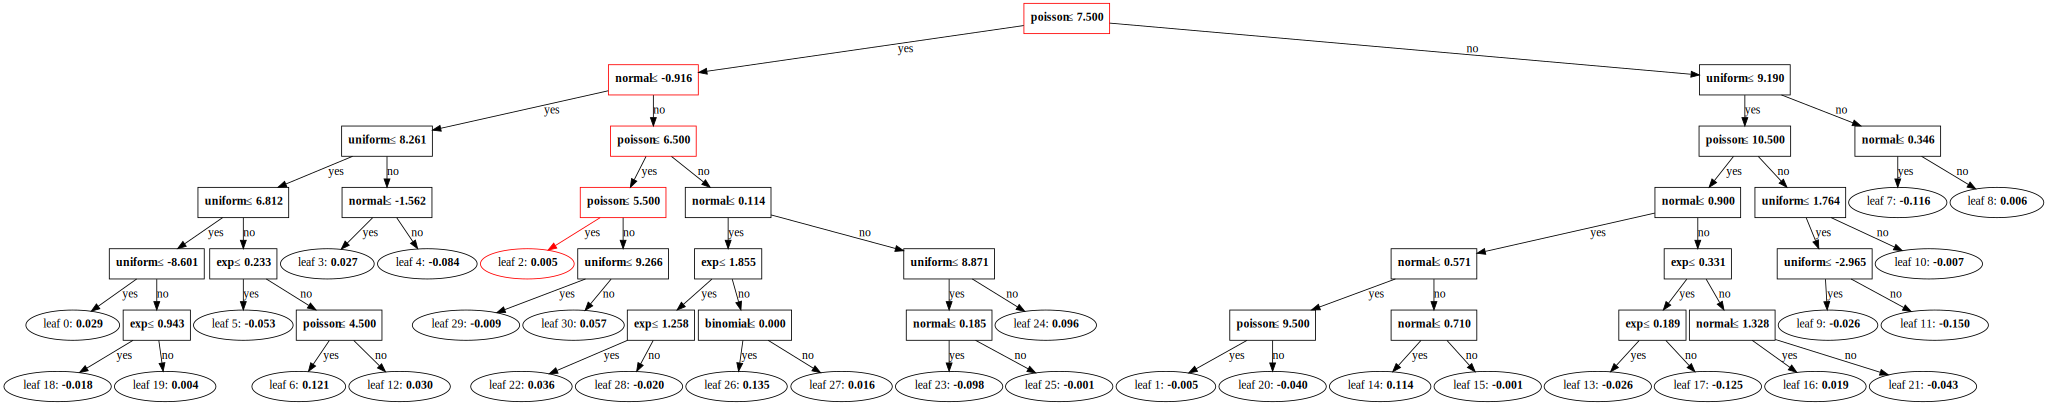

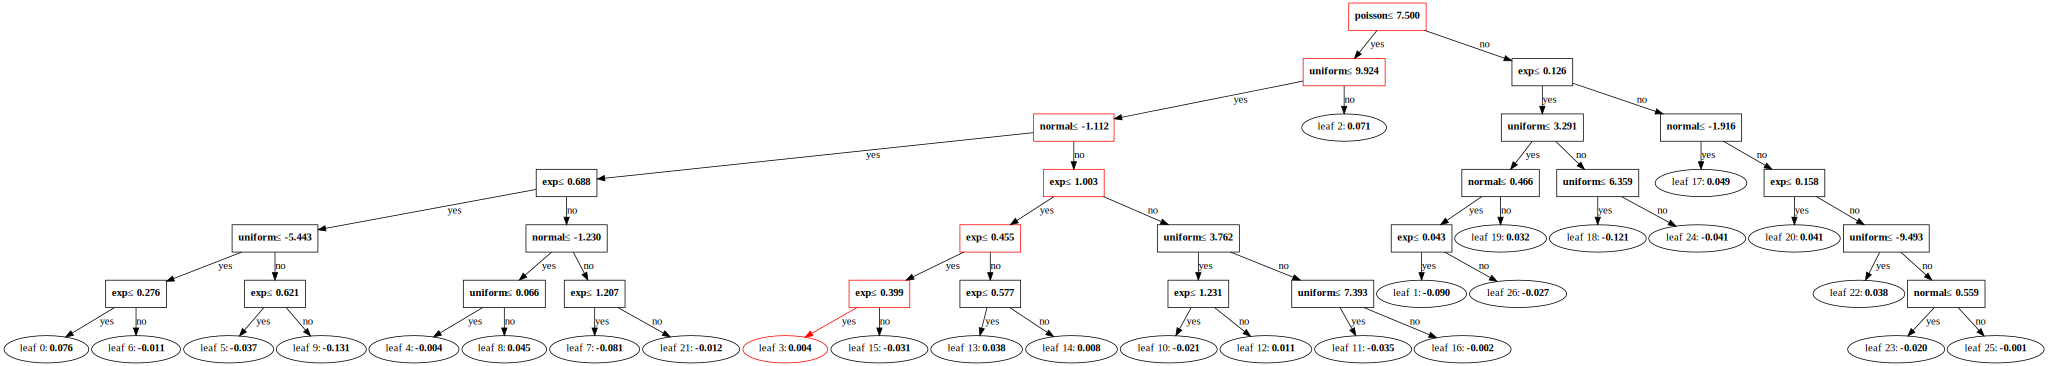

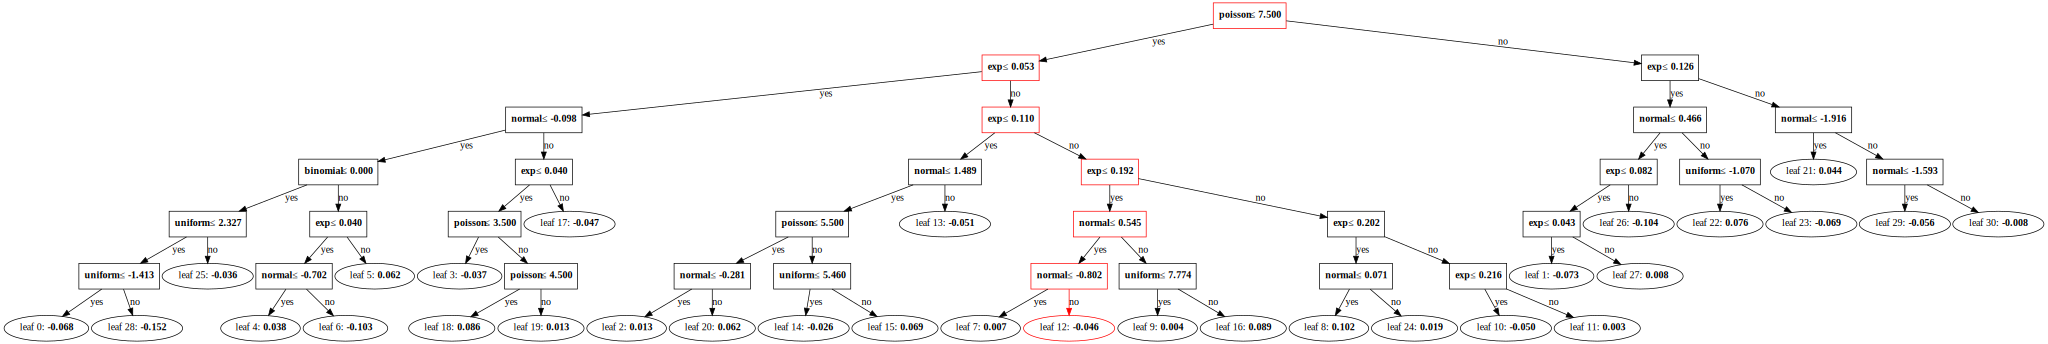

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import graphviz
from IPython.display import Image, display
from sklearn.metrics import f1_score
import re
import shap
import lime
import lime.lime_tabular

def predict_path(tree_structure, sample):
        current_node = tree_structure
        path = []
        while 'leaf_index' not in current_node:
            feature_idx = current_node['split_feature']
            threshold = current_node['threshold']
            feature_value = sample.iloc[feature_idx]
            path.append({
                'feature': feature_idx,
                'threshold': threshold,
                'value': feature_value,
                'direction': '<=' if feature_value <= threshold else '>'
            })
            if feature_value <= threshold:
                current_node = current_node['left_child']
            else:
                current_node = current_node['right_child']
        return path, current_node
def visualize_tree_paths(df, model, object_index, n_trees=None):

    first_object = X_test.iloc[object_index]
    columns = df.columns
    dumped_model = model.booster_.dump_model()

    if n_trees is None:
        n_trees = model.n_estimators

    for tree_index in range(n_trees):
        tree_info = dumped_model['tree_info'][tree_index]['tree_structure']
        path, leaf = predict_path(tree_info, first_object)
        leaf = leaf['leaf_index']

        dot_data = lgb.create_tree_digraph(model.booster_, orientation='vertical', tree_index=tree_index)
        dot_source = dot_data.source

        highlighted_lines = []
        for line in dot_source.splitlines():
            find = False
            for item in path:
                f = columns[item['feature']]
                if re.search(rf'\b{f}\b', line) and str(round(item['threshold'], 3)) in line:
                    highlighted_lines.append(line.replace('color=black', 'color=red'))
                    find = True
                    break
            if not find and re.search(rf'\bleaf{leaf}\b', line):
                highlighted_lines.append(line.replace('color=black', 'color=red'))
                find = True
            if not find:
                highlighted_lines.append(line)


        highlighted_dot_source = "\n".join(highlighted_lines)
        highlighted_graph = graphviz.Source(highlighted_dot_source)
        display(highlighted_graph)


n_samples = 10000
normal_feature = np.random.normal(loc=0, scale=1, size=n_samples)
uniform_feature = np.random.uniform(low=-10, high=10, size=n_samples)
binomial_feature = np.random.binomial(n=1, p=0.5, size=n_samples)
exp_feature = np.random.exponential(scale=1, size=n_samples)
poisson_feature = np.random.poisson(lam=5, size=n_samples)
target = np.random.choice([0, 1], size=n_samples)

df = pd.DataFrame({
    'normal': normal_feature,
    'uniform': uniform_feature,
    'binomial': binomial_feature,
    'exp': exp_feature,
    'poisson': poisson_feature,
    'Target': target
})

X = df.drop('Target', axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(objective='binary', n_estimators=5, max_depth=6, random_state=42)
model.fit(X_train, y_train)

print('F1_score')
print(f1_score(y_test, model.predict(X_test)))

# Вызов функции для визуализации путей по дереву
# Индекс из X_test
visualize_tree_paths(df, model, object_index=0)  # Пример вызова функции

In [ ]:
f = {'split_index': 8, 'split_feature': 0, 'split_gain': 3.727720022201538, 'threshold': 0.2540049380673796, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.00298452, 'internal_weight': 954.491, 'internal_count': 3822, 'left_child': {'leaf_index': 2, 'leaf_value': -0.01443455023259927, 'leaf_weight': 219.07425253093243, 'leaf_count': 877}, 'right_child': {'leaf_index': 9, 'leaf_value': 0.00042634581199051124, 'leaf_weight': 735.4164471179247, 'leaf_count': 2945}}

In [ ]:
'leaf_index' not in f

True

In [ ]:
f

{'split_index': 8,
 'split_feature': 0,
 'split_gain': 3.727720022201538,
 'threshold': 0.2540049380673796,
 'decision_type': '<=',
 'default_left': True,
 'missing_type': 'None',
 'internal_value': -0.00298452,
 'internal_weight': 954.491,
 'internal_count': 3822,
 'left_child': {'leaf_index': 2,
  'leaf_value': -0.01443455023259927,
  'leaf_weight': 219.07425253093243,
  'leaf_count': 877},
 'right_child': {'leaf_index': 9,
  'leaf_value': 0.00042634581199051124,
  'leaf_weight': 735.4164471179247,
  'leaf_count': 2945}}

In [ ]:
f['left_child']

{'leaf_index': 2,
 'leaf_value': -0.01443455023259927,
 'leaf_weight': 219.07425253093243,
 'leaf_count': 877}

In [ ]:
f2 = {'split_index': 5, 'split_feature': 3, 'split_gain': 7.035520076751709, 'threshold': 3.5332322697988046, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.00205868, 'internal_weight': 965.721, 'internal_count': 3867, 'left_child': {'split_index': 8, 'split_feature': 0, 'split_gain': 3.727720022201538, 'threshold': 0.2540049380673796, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.00298452, 'internal_weight': 954.491, 'internal_count': 3822, 'left_child': {'leaf_index': 2, 'leaf_value': -0.01443455023259927, 'leaf_weight': 219.07425253093243, 'leaf_count': 877}, 'right_child': {'leaf_index': 9, 'leaf_value': 0.00042634581199051124, 'leaf_weight': 735.4164471179247, 'leaf_count': 2945}}, 'right_child': {'split_index': 20, 'split_feature': 2, 'split_gain': 2.945039987564087, 'threshold': 1.0000000180025095e-35, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 0.0766296, 'internal_weight': 11.2304, 'internal_count': 45, 'left_child': {'leaf_index': 6, 'leaf_value': 0.02654247056755023, 'leaf_weight': 5.739584460854529, 'leaf_count': 23}, 'right_child': {'leaf_index': 21, 'leaf_value': 0.12898595783599204, 'leaf_weight': 5.490830183029175, 'leaf_count': 22}}}

In [ ]:
'leaf_index' not in f2

True

In [ ]:
from scipy.special import expit
raw_scores = model.predict(X_test[:1], pred_contrib=True)
print(raw_scores)

tree_contributions = np.sum(raw_scores)
print(tree_contributions)
probabilities = expit(tree_contributions)


print("Вероятность для первого экземпляра:", probabilities)
print("Вероятность с использованием predict_proba:", model.predict_proba(X_test[:1]))
print(model.predict_proba(X_test[:1],pred_leaf = True ))
model.predict_proba(X_test[:1], raw_score = True)

[[ 0.00395241  0.00155932 -0.00012979 -0.01738389 -0.00206723 -0.01705331]]
-0.031122491430960263
Вероятность для первого экземпляра: 0.49222000511351793
Вероятность с использованием predict_proba: [[0.50777999 0.49222001]]
[[13 19  2  3 12]]


array([-0.03112249])

In [ ]:
def add_shap_values(model, df, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df[feature_names])
    shap_df = pd.DataFrame(shap_values, columns=[f'shap_{col}' for col in feature_names])
    return pd.concat([df, shap_df], axis=1)

def add_lime_values(model, df, feature_names):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=df[feature_names].values,
        feature_names=feature_names,
        mode='classification',
        random_state=42
    )
    # Долго...
    lime_values = np.zeros((len(df), len(feature_names)))
    for idx in range(len(df)):
        exp = explainer.explain_instance(
            df[feature_names].iloc[idx].values,
            model.predict_proba,
            num_features=len(feature_names)
        )
        feat_importance = dict(exp.local_exp[1])
        for feat_idx in range(len(feature_names)):
            lime_values[idx, feat_idx] = feat_importance[feat_idx]

    lime_df = pd.DataFrame(lime_values, columns=[f'lime_{col}' for col in feature_names])
    return pd.concat([df, lime_df], axis=1)

df = add_shap_values(model, df, X_test.columns)
df = add_lime_values(model, df, X_test.columns)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [ ]:
df

,normal,uniform,binomial,exp,poisson,Target,shap_normal,shap_uniform,shap_binomial,shap_exp,shap_poisson,lime_normal,lime_uniform,lime_binomial,lime_exp,lime_poisson
0,2.094938,9.829829,1,0.587719,2,0,0.010670,0.021292,-0.000141,0.028687,0.009346,0.003148,0.000826,0.000802,0.004854,0.007555
1,-0.264852,-0.361615,1,1.452577,3,0,0.003491,0.001189,0.000094,0.006432,0.018467,-0.000287,-0.002328,0.000438,0.003464,0.005732
2,-0.199431,2.769735,0,0.835192,3,1,0.007377,0.001957,0.000213,0.005285,0.011897,-0.000551,-0.000411,0.001129,0.000212,0.007065
3,-0.168302,4.880418,1,0.779074,2,1,0.007094,-0.004584,-0.000236,0.012377,0.012080,-0.000795,0.000059,-0.000187,-0.000348,0.006123
4,-0.042185,-2.219439,1,0.774688,5,1,0.016442,-0.002296,-0.000206,0.001515,0.011276,-0.000068,-0.002396,-0.000748,-0.000515,0.006392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.634776,-7.530606,1,0.870441,12,0,0.000184,0.014832,-0.000502,0.005118,-0.074428,0.001454,0.001798,-0.000285,-0.000385,-0.013187
9996,1.358188,-1.471045,0,0.012800,9,0,0.065119,0.060988,-0.000677,0.012457,-0.065783,0.002926,-0.003266,-0.000162,-0.008201,-0.013967
9997,-1.680422,-3.832762,0,2.593865,6,0,-0.023636,-0.020700,0.000596,0.028885,-0.000852,-0.005221,-0.002041,-0.000272,0.003784,-0.002637
9998,1.366052,-4.104236,1,1.398206,5,1,-0.011082,0.003117,-0.000113,-0.006054,0.012787,0.002221,-0.002001,0.000225,0.002425,0.006907


In [ ]:
def get_paths_and_deviations(model, X):
    """
    Функция для получения длин путей и характеристик прохождения деревьев

    Parameters:
    model: LGBMClassifier - обученная модель
    X: pd.DataFrame - данные для анализа

    Returns:
    path_lengths: список длин путей для каждого дерева
    min_deviations: словарь минимальных отклонений для каждого признака
    split_gains: список списков split_gain для каждого объекта
    leaf_weights: список весов листьев для каждого объекта
    leaf_counts: список количества объектов в листьях для каждого объекта
    """

    dumped_model = model.booster_.dump_model()
    trees = dumped_model['tree_info']

    def predict_path_with_info(tree_structure, sample):
        current_node = tree_structure
        path = []
        deviations = {i: None for i in range(len(sample))}
        gains = []

        while 'leaf_index' not in current_node:
            feature_idx = current_node['split_feature']
            threshold = current_node['threshold']
            feature_value = sample.iloc[feature_idx]

            # Сохраняем split_gain
            gains.append(current_node['split_gain'])

            # Вычисляем отклонение
            deviation = abs(feature_value - threshold)

            if deviations[feature_idx] is None:
                deviations[feature_idx] = deviation
            else:
                deviations[feature_idx] = min(deviations[feature_idx], deviation)

            path.append({
                'feature': feature_idx,
                'threshold': threshold,
                'value': feature_value,
                'direction': '<=' if feature_value <= threshold else '>'
            })

            if feature_value <= threshold:
                current_node = current_node['left_child']
            else:
                current_node = current_node['right_child']

        # Получаем информацию о листе
        leaf_weight = current_node['leaf_weight']
        leaf_count = current_node['leaf_count']

        return len(path), deviations, gains, leaf_weight, leaf_count

    all_path_lengths = []
    all_deviations = {i: [] for i in range(len(X.columns))}
    all_split_gains = []
    all_leaf_weights = []
    all_leaf_counts = []

    # Проходим по всем объектам
    for idx, sample in X.iterrows():
        sample_path_lengths = []
        sample_deviations = {i: None for i in range(len(sample))}
        sample_split_gains = []
        sample_leaf_weights = []
        sample_leaf_counts = []

        # Проходим по всем деревьям
        for tree in trees:
            path_length, deviations, gains, leaf_weight, leaf_count = predict_path_with_info(
                tree['tree_structure'], sample
            )
            sample_path_lengths.append(path_length)
            sample_split_gains.append(gains)
            sample_leaf_weights.append(leaf_weight)
            sample_leaf_counts.append(leaf_count)

            # Обновляем минимальные отклонения
            for feature, deviation in deviations.items():
                if deviation is not None:
                    if sample_deviations[feature] is None:
                        sample_deviations[feature] = deviation
                    else:
                        sample_deviations[feature] = min(sample_deviations[feature], deviation)

        all_path_lengths.append(sample_path_lengths)
        all_split_gains.append(sample_split_gains)
        all_leaf_weights.append(sample_leaf_weights)
        all_leaf_counts.append(sample_leaf_counts)

        # Обновляем глобальные минимальные отклонения
        for feature, deviation in sample_deviations.items():
            all_deviations[feature].append(deviation)

    return all_path_lengths, all_deviations, all_split_gains, all_leaf_weights, all_leaf_counts

def add_paths_and_deviations_to_df(data, path_lengths, deviations, split_gains, leaf_weights, leaf_counts):
    """
    Функция для добавления информации о путях и характеристиках в DataFrame

    Parameters:
    data: pd.DataFrame - исходный датафрейм
    path_lengths: список длин путей для каждого дерева
    deviations: словарь минимальных отклонений для каждого признака
    split_gains: список списков split_gain для каждого объекта
    leaf_weights: список весов листьев для каждого объекта
    leaf_counts: список количества объектов в листьях для каждого объекта

    Returns:
    data: pd.DataFrame - обновленный датафрейм с новыми столбцами
    """

    # Добавляем статистики по длинам путей
    data['tree_mean_path_length'] = [np.mean(paths) for paths in path_lengths]
    data['tree_std_path_length'] = [np.std(paths) for paths in path_lengths]
    data['tree_min_path_length'] = [np.min(paths) for paths in path_lengths]
    data['tree_max_path_length'] = [np.max(paths) for paths in path_lengths]

    # Добавляем статистики по split_gains
    data['tree_mean_split_gain'] = [np.mean([gain for tree_gains in gains for gain in tree_gains])
                              for gains in split_gains]
    data['tree_std_split_gain'] = [np.std([gain for tree_gains in gains for gain in tree_gains])
                             for gains in split_gains]
    data['tree_min_split_gain'] = [np.min([gain for tree_gains in gains for gain in tree_gains])
                             for gains in split_gains]
    data['tree_max_split_gain'] = [np.max([gain for tree_gains in gains for gain in tree_gains])
                             for gains in split_gains]

    # Добавляем статистики по leaf_weights (последние листы)
    data['tree_mean_leaf_weight'] = [np.mean(weights) for weights in leaf_weights]
    data['tree_std_leaf_weight'] = [np.std(weights) for weights in leaf_weights]
    data['tree_min_leaf_weight'] = [np.min(weights) for weights in leaf_weights]
    data['tree_max_leaf_weight'] = [np.max(weights) for weights in leaf_weights]

    # Добавляем статистики по leaf_counts (последние листы)
    data['tree_mean_leaf_count'] = [np.mean(counts) for counts in leaf_counts]
    data['tree_std_leaf_count'] = [np.std(counts) for counts in leaf_counts]
    data['tree_min_leaf_count'] = [np.min(counts) for counts in leaf_counts]
    data['tree_max_leaf_count'] = [np.max(counts) for counts in leaf_counts]

    # Добавляем отклонения для каждого признака
    for feature_idx in deviations.keys():
        feature_name = data.columns[feature_idx]
        # Добавляем отклонения для каждого признака
        feature_name = data.columns[feature_idx]
        deviation_column_name = f'tree_deviation_{feature_name}'

        # Преобразуем None в np.nan
        deviation_values = [np.nan if x is None else x for x in deviations[feature_idx]]
        data[deviation_column_name] = deviation_values


        # has_predicate_column = f'has_predicate_{feature_name}'
        # data[has_predicate_column] = [not pd.isna(x) for x in deviation_values]

        #print(f"Feature {feature_name}: {sum(pd.isna(deviation_values))} objects without predicate")

    return data

# Пример использования:
path_lengths, deviations, split_gains, leaf_weights, leaf_counts = get_paths_and_deviations(model, X)
df = add_paths_and_deviations_to_df(df, path_lengths, deviations, split_gains, leaf_weights, leaf_counts)

In [ ]:
df

,normal,uniform,binomial,exp,poisson,Target,shap_normal,shap_uniform,shap_binomial,shap_exp,...,tree_max_leaf_weight,tree_mean_leaf_count,tree_std_leaf_count,tree_min_leaf_count,tree_max_leaf_count,tree_deviation_normal,tree_deviation_uniform,tree_deviation_binomial,tree_deviation_exp,tree_deviation_poisson
0,2.094938,9.829829,1,0.587719,2,0,0.010670,0.021292,-0.000141,0.028687,...,1394.484862,3011.4,1963.003067,281,5583,0.179941,0.094623,NaN,0.010865,3.5
1,-0.264852,-0.361615,1,1.452577,3,0,0.003491,0.001189,0.000094,0.006432,...,1394.484862,3428.4,1502.150538,1239,5583,0.603857,4.124109,NaN,0.221323,2.5
2,-0.199431,2.769735,0,0.835192,3,1,0.007377,0.001957,0.000213,0.005285,...,1394.484862,3421.6,1512.090288,1205,5583,0.669278,7.154717,NaN,0.102524,2.5
3,-0.168302,4.880418,1,0.779074,2,1,0.007094,-0.004584,-0.000236,0.012377,...,1394.484862,3421.6,1512.090288,1205,5583,0.700407,5.044034,NaN,0.046407,3.5
4,-0.042185,-2.219439,1,0.774688,5,1,0.016442,-0.002296,-0.000206,0.001515,...,1394.484862,3421.6,1512.090288,1205,5583,0.826523,12.143891,NaN,0.042020,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.634776,-7.530606,1,0.870441,12,0,0.000184,0.014832,-0.000502,0.005118,...,217.376905,465.0,289.124195,40,872,1.075650,1.962685,NaN,0.376424,1.5
9996,1.358188,-1.471045,0,0.012800,9,0,0.065119,0.060988,-0.000677,0.012457,...,8.951343,28.0,5.585696,21,36,0.283276,0.401396,NaN,0.112857,1.5
9997,-1.680422,-3.832762,0,2.593865,6,0,-0.023636,-0.020700,0.000596,0.028885,...,1394.484862,1427.2,2080.862744,214,5583,0.450775,3.619148,NaN,0.187887,1.5
9998,1.366052,-4.104236,1,1.398206,5,1,-0.011082,0.003117,-0.000113,-0.006054,...,1394.484862,3029.0,1941.736851,335,5583,0.092283,7.866731,NaN,0.166952,0.5


In [ ]:
df

,normal,uniform,binomial,exp,poisson,Target,shap_normal,shap_uniform,shap_binomial,shap_exp,...,tree_max_leaf_weight,tree_mean_leaf_count,tree_std_leaf_count,tree_min_leaf_count,tree_max_leaf_count,tree_deviation_normal,tree_deviation_uniform,tree_deviation_binomial,tree_deviation_exp,tree_deviation_poisson
0,2.094938,9.829829,1,0.587719,2,0,0.010670,0.021292,-0.000141,0.028687,...,1394.484862,3011.4,1963.003067,281,5583,0.179941,0.094623,NaN,0.010865,3.5
1,-0.264852,-0.361615,1,1.452577,3,0,0.003491,0.001189,0.000094,0.006432,...,1394.484862,3428.4,1502.150538,1239,5583,0.603857,4.124109,NaN,0.221323,2.5
2,-0.199431,2.769735,0,0.835192,3,1,0.007377,0.001957,0.000213,0.005285,...,1394.484862,3421.6,1512.090288,1205,5583,0.669278,7.154717,NaN,0.102524,2.5
3,-0.168302,4.880418,1,0.779074,2,1,0.007094,-0.004584,-0.000236,0.012377,...,1394.484862,3421.6,1512.090288,1205,5583,0.700407,5.044034,NaN,0.046407,3.5
4,-0.042185,-2.219439,1,0.774688,5,1,0.016442,-0.002296,-0.000206,0.001515,...,1394.484862,3421.6,1512.090288,1205,5583,0.826523,12.143891,NaN,0.042020,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.634776,-7.530606,1,0.870441,12,0,0.000184,0.014832,-0.000502,0.005118,...,217.376905,465.0,289.124195,40,872,1.075650,1.962685,NaN,0.376424,1.5
9996,1.358188,-1.471045,0,0.012800,9,0,0.065119,0.060988,-0.000677,0.012457,...,8.951343,28.0,5.585696,21,36,0.283276,0.401396,NaN,0.112857,1.5
9997,-1.680422,-3.832762,0,2.593865,6,0,-0.023636,-0.020700,0.000596,0.028885,...,1394.484862,1427.2,2080.862744,214,5583,0.450775,3.619148,NaN,0.187887,1.5
9998,1.366052,-4.104236,1,1.398206,5,1,-0.011082,0.003117,-0.000113,-0.006054,...,1394.484862,3029.0,1941.736851,335,5583,0.092283,7.866731,NaN,0.166952,0.5


In [ ]:
dumped_model = model.booster_.dump_model()
trees = dumped_model['tree_info']

def predict_path_with_info(tree_structure, sample):
    current_node = tree_structure
    path = []
    deviations = {i: None for i in range(len(sample))}
    gains = []

    while 'leaf_index' not in current_node:
        feature_idx = current_node['split_feature']
        threshold = current_node['threshold']
        feature_value = sample.iloc[feature_idx]
        gains.append(current_node['split_gain'])
        deviation = abs(feature_value - threshold)

        if deviations[feature_idx] is None:
            deviations[feature_idx] = deviation
        else:
            deviations[feature_idx] = min(deviations[feature_idx], deviation)

        path.append({
            'feature': feature_idx,
            'threshold': threshold,
            'value': feature_value,
            'direction': '<=' if feature_value <= threshold else '>'
        })

        if feature_value <= threshold:
            current_node = current_node['left_child']
        else:
            current_node = current_node['right_child']

    leaf_value = current_node['leaf_value']
    leaf_count = current_node['leaf_count']

    return len(path), deviations, gains, leaf_value, leaf_count

def predict_and_analyze(trees, X):
    for i, sample in X.iterrows():
        total_contribution = 0
        for j, tree in enumerate(trees):

            path_length, deviations, gains, leaf_value, leaf_count = predict_path_with_info(tree['tree_structure'], sample)
            print(leaf_value)
            total_contribution += leaf_value #* 0.1

        probability = 1 / (1 + np.exp(-total_contribution))
        print(f"Object {i}: Final Probability = {probability}")

predict_and_analyze(trees, X[:1])

-0.010839755515302394
0.04763256627501188
0.004933547784179217
0.007735067192734538
0.003339092832322416
Object 0: Final Probability = 0.5131970637826067


In [ ]:
dumped_model

{'name': 'tree',
 'version': 'v4',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 4,
 'objective': 'binary sigmoid:1',
 'average_output': False,
 'feature_names': ['normal', 'uniform', 'binomial', 'exp', 'poisson'],
 'monotone_constraints': [],
 'feature_infos': {'normal': {'min_value': -3.5273808957547867,
   'max_value': 3.180283417595444,
   'values': []},
  'uniform': {'min_value': -9.999205185665438,
   'max_value': 9.996802097752337,
   'values': []},
  'binomial': {'min_value': 0, 'max_value': 1, 'values': []},
  'exp': {'min_value': 6.738277942607754e-05,
   'max_value': 8.935140161644549,
   'values': []},
  'poisson': {'min_value': 0, 'max_value': 15, 'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 31,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 4,
    'split_gain': 9.952890396118164,
    'threshold': 7.500000000000001,
    'decision_type': '<=',
    'default_left': T